<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

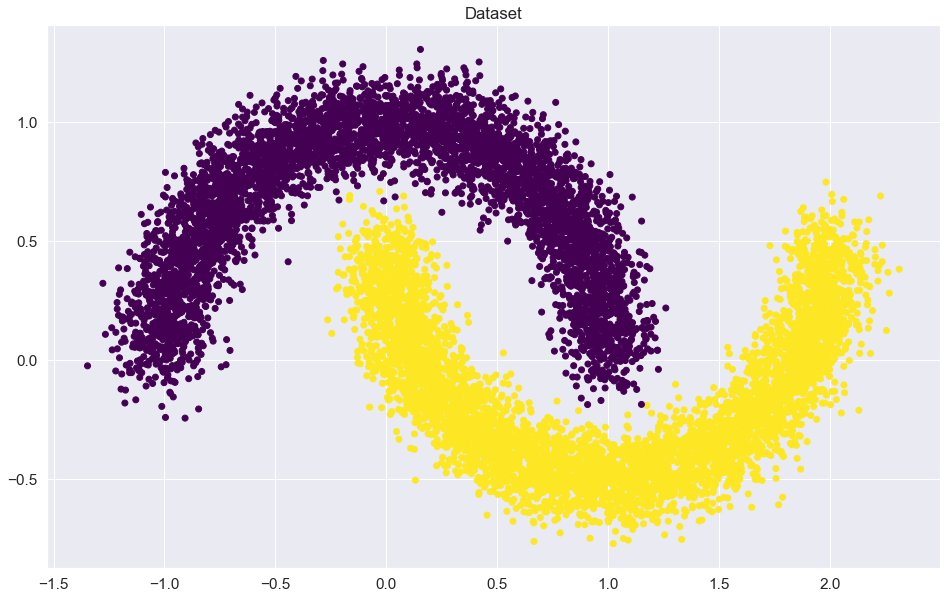

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
torch.Tensor(np.array([1])).to(torch.float32)

tensor([1.])

In [6]:
X_train_t =  torch.Tensor(X_train).to(torch.float32)
y_train_t =  torch.Tensor(y_train).to(torch.float32)
X_val_t =  torch.Tensor(X_val).to(torch.float32)
y_val_t =  torch.Tensor(y_val).to(torch.float32)

Создаем `Dataset` и `DataLoader`. 

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn([in_features, out_features]))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  torch.matmul(x, self.weights)
        if self.bias:
            x += self.bias_term
        return x

In [9]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [10]:
total_params = 0
for name, parameter in linear_regression.named_parameters():
    if not parameter.requires_grad:
        continue
    param = parameter.numel()
    total_params += param

In [11]:
total_params

3

**Ответ:**  3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [13]:
tol = 1e-3
losses = []
max_epochs = 1000
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        y_batch = y_batch.unsqueeze(1)
        optimizer.zero_grad()
        outp =  linear_regression.forward(X_batch)
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = F.softmax(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

/Users/timur/.pyenv/versions/3.7.10/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Iteration: 0
Batch accuracy: 62.0
Iteration: 100
Batch accuracy: 70.0
Iteration: 200
Batch accuracy: 59.0
Iteration: 300
Batch accuracy: 74.0
Iteration: 400
Batch accuracy: 61.0
Iteration: 500
Batch accuracy: 63.0
Iteration: 600
Batch accuracy: 52.0
Iteration: 700
Batch accuracy: 66.0

Iteration: 759.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 759

### Визуализируем результаты

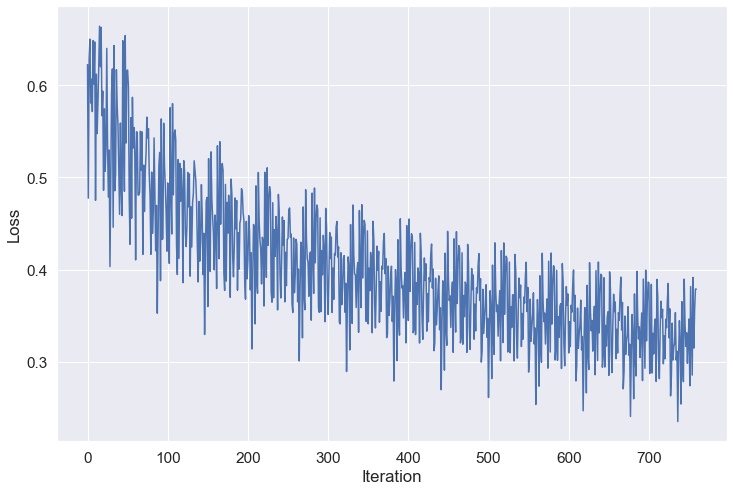

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

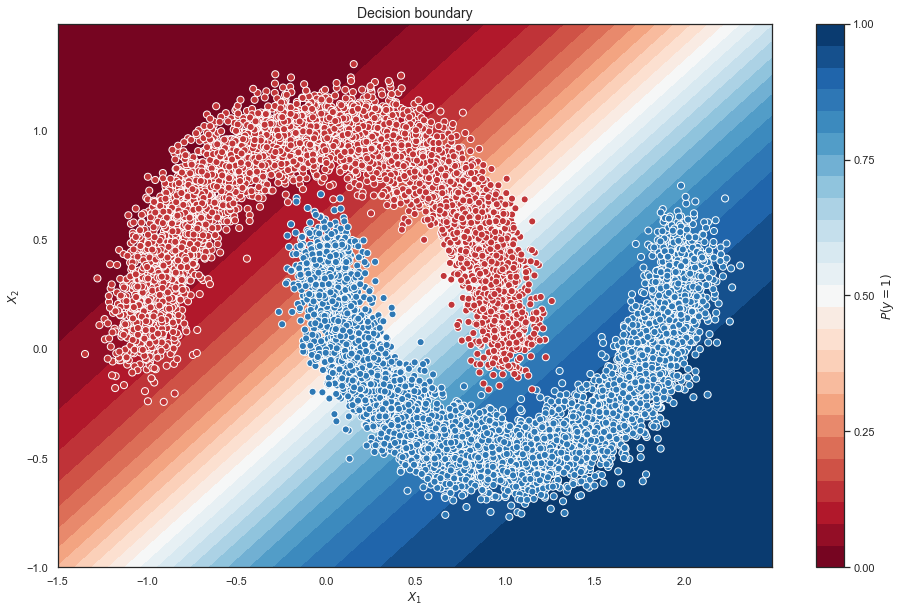

In [17]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [18]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model.forward(X_batch)
        probabilities = F.softmax(outp, dim=1)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [19]:
y_val_pred = predict(val_dataloader, linear_regression)

In [20]:
y_val_pred[:y_val_t.shape[0]].shape

(2500,)

In [21]:
from sklearn.metrics import accuracy_score

y_val_pred = predict(val_dataloader, linear_regression)
accuracy_score(y_val_t.numpy(), y_val_pred[:y_val_t.shape[0]])

0.4912

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.4912

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [22]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './data'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=False)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=False)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=0)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [23]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [24]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10),
)

In [25]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [32]:
#pip install tqdm
from tqdm.notebook import tqdm_notebook as tqdm

### Задание. Дополните цикл обучения.

In [33]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [34]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm(range(max_epochs)):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                optimizer.zero_grad()
                model.train()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = sum(y_batch == preds)
            all = y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.9033833333333333
Loader: valid. Accuracy: 0.9404
Epoch: 2
Loader: train. Accuracy: 0.9574
Loader: valid. Accuracy: 0.9623
Epoch: 3
Loader: train. Accuracy: 0.96755
Loader: valid. Accuracy: 0.967
Epoch: 4
Loader: train. Accuracy: 0.9749166666666667
Loader: valid. Accuracy: 0.9628
Epoch: 5
Loader: train. Accuracy: 0.9765166666666667
Loader: valid. Accuracy: 0.9749
Epoch: 6
Loader: train. Accuracy: 0.9809833333333333
Loader: valid. Accuracy: 0.9669
Epoch: 7
Loader: train. Accuracy: 0.9818166666666667
Loader: valid. Accuracy: 0.972
Epoch: 8
Loader: train. Accuracy: 0.9838333333333333
Loader: valid. Accuracy: 0.9775
Epoch: 9
Loader: train. Accuracy: 0.9853
Loader: valid. Accuracy: 0.9761
Epoch: 10
Loader: train. Accuracy: 0.9870833333333333
Loader: valid. Accuracy: 0.9784


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [36]:
elu_accuracy = accuracy["valid"]

In [38]:
def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10),
    )
    optimizer = torch.optim.Adam(model.parameters())
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in tqdm(range(max_epochs)):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    optimizer.zero_grad()
                    model.train()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = sum(y_batch == preds)
                all = y_batch.shape[0]
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy['valid']

In [39]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8749666666666667
Loader: valid. Accuracy: 0.8988
Epoch: 2
Loader: train. Accuracy: 0.89935
Loader: valid. Accuracy: 0.9112
Epoch: 3
Loader: train. Accuracy: 0.9045
Loader: valid. Accuracy: 0.9052
Epoch: 4
Loader: train. Accuracy: 0.9058666666666667
Loader: valid. Accuracy: 0.907
Epoch: 5
Loader: train. Accuracy: 0.9089166666666667
Loader: valid. Accuracy: 0.9102
Epoch: 6
Loader: train. Accuracy: 0.90935
Loader: valid. Accuracy: 0.9089
Epoch: 7
Loader: train. Accuracy: 0.9104333333333333
Loader: valid. Accuracy: 0.913
Epoch: 8
Loader: train. Accuracy: 0.9122333333333333
Loader: valid. Accuracy: 0.9074
Epoch: 9
Loader: train. Accuracy: 0.91315
Loader: valid. Accuracy: 0.91
Epoch: 10
Loader: train. Accuracy: 0.915
Loader: valid. Accuracy: 0.9161


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8873
Loader: valid. Accuracy: 0.9381
Epoch: 2
Loader: train. Accuracy: 0.9478666666666666
Loader: valid. Accuracy: 0.9604
Epoch: 3
Loader: train. Accuracy: 0.9618666666666666
Loader: valid. Accuracy: 0.9575
Epoch: 4
Loader: train. Accuracy: 0.9676166666666667
Loader: valid. Accuracy: 0.9702
Epoch: 5
Loader: train. Accuracy: 0.9723
Loader: valid. Accuracy: 0.9712
Epoch: 6
Loader: train. Accuracy: 0.97575
Loader: valid. Accuracy: 0.9734
Epoch: 7
Loader: train. Accuracy: 0.9783
Loader: valid. Accuracy: 0.9716
Epoch: 8
Loader: train. Accuracy: 0.9807833333333333
Loader: valid. Accuracy: 0.9745
Epoch: 9
Loader: train. Accuracy: 0.9824666666666667
Loader: valid. Accuracy: 0.9749
Epoch: 10
Loader: train. Accuracy: 0.9829333333333333
Loader: valid. Accuracy: 0.9742


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8912833333333333
Loader: valid. Accuracy: 0.946
Epoch: 2
Loader: train. Accuracy: 0.9502666666666667
Loader: valid. Accuracy: 0.9567
Epoch: 3
Loader: train. Accuracy: 0.9633666666666667
Loader: valid. Accuracy: 0.9688
Epoch: 4
Loader: train. Accuracy: 0.9685
Loader: valid. Accuracy: 0.9649
Epoch: 5
Loader: train. Accuracy: 0.97385
Loader: valid. Accuracy: 0.9693
Epoch: 6
Loader: train. Accuracy: 0.9767833333333333
Loader: valid. Accuracy: 0.9713
Epoch: 7
Loader: train. Accuracy: 0.9796
Loader: valid. Accuracy: 0.9754
Epoch: 8
Loader: train. Accuracy: 0.9808333333333333
Loader: valid. Accuracy: 0.9676
Epoch: 9
Loader: train. Accuracy: 0.98365
Loader: valid. Accuracy: 0.9744
Epoch: 10
Loader: train. Accuracy: 0.98315
Loader: valid. Accuracy: 0.9739


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

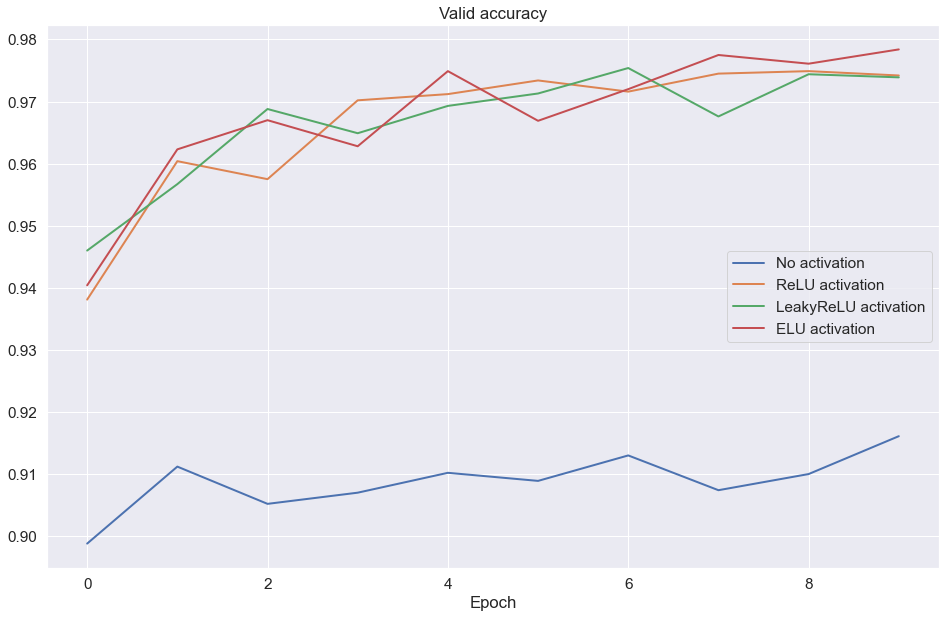

In [41]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

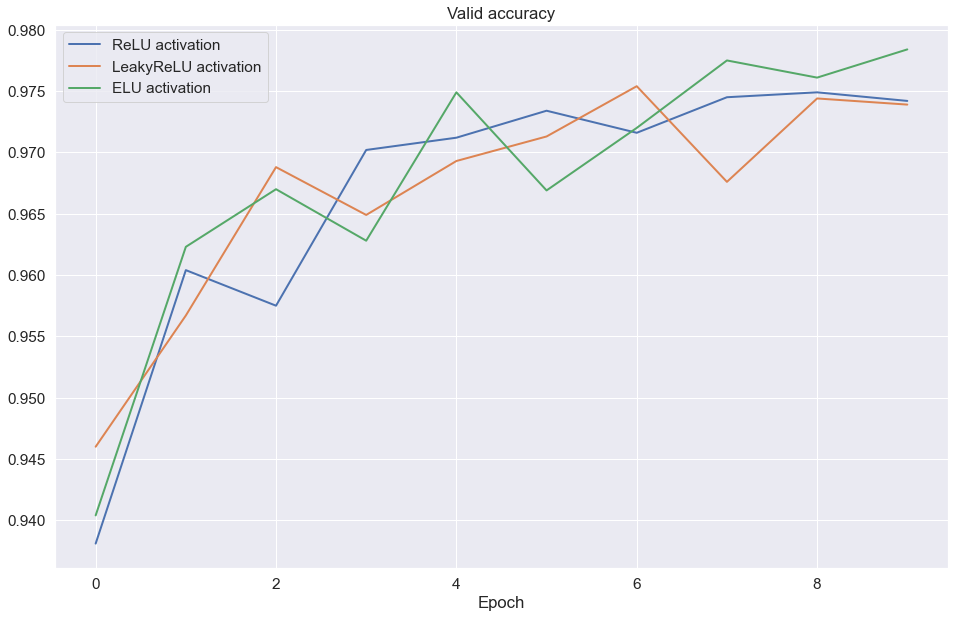

In [43]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [44]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-10-21 20:24:11--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Распознаётся img.the-village.kz (img.the-village.kz)… 144.76.208.75
Подключение к img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 301 Moved Permanently
Адрес: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [переход]
--2022-10-21 20:24:11--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Распознаётся img.the-village-kz.com (img.the-village-kz.com)… 144.76.208.75
Подключение к img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 49337 (48K) [image/jpeg]
Сохранение в: «sample_photo.jpg»

sample_photo.jpg    100%[===================>]  48,18K  --.-KB/s    за 0,08s   

2022-10-21 20:24:12 (579 KB/s) - «sample_

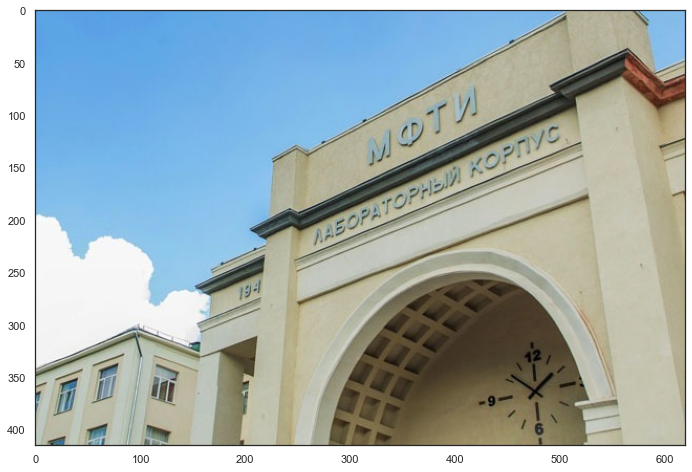

In [45]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [46]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

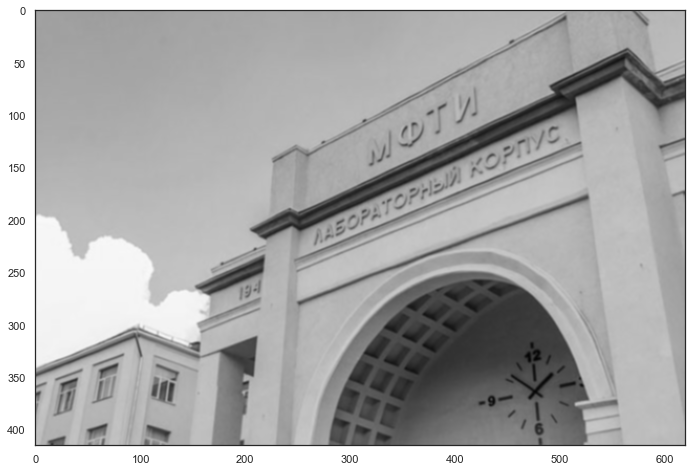

In [47]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие - Е

2) Увеличение резкости - Д

3) Тождественное преобразование - А

4) Выделение вертикальных границ - В

5) Выделение горизонтальных границ - Б

6) Выделение границ - Г

**Ответ:** Е Д А В Б Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [48]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.pool2 = nn.MaxPool2d((2, 2))
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.flatten(1, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [83]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.7)
loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [84]:
max_epochs = 20
accuracy = {"train": [], "valid": []}
for epoch in tqdm(range(max_epochs)):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                optimizer.zero_grad()
                model.train()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = sum(y_batch == preds)
            all = y_batch.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.5344166666666667
Loader: valid. Accuracy: 0.7768
Epoch: 2
Loader: train. Accuracy: 0.7839666666666667
Loader: valid. Accuracy: 0.7921
Epoch: 3
Loader: train. Accuracy: 0.79275
Loader: valid. Accuracy: 0.7964
Epoch: 4
Loader: train. Accuracy: 0.7963666666666667
Loader: valid. Accuracy: 0.7989
Epoch: 5
Loader: train. Accuracy: 0.7985666666666666
Loader: valid. Accuracy: 0.8003
Epoch: 6
Loader: train. Accuracy: 0.8416833333333333
Loader: valid. Accuracy: 0.8873
Epoch: 7
Loader: train. Accuracy: 0.8888
Loader: valid. Accuracy: 0.8884
Epoch: 8
Loader: train. Accuracy: 0.8900333333333333
Loader: valid. Accuracy: 0.8883
Epoch: 9
Loader: train. Accuracy: 0.8915
Loader: valid. Accuracy: 0.8904
Epoch: 10
Loader: train. Accuracy: 0.8925833333333333
Loader: valid. Accuracy: 0.8893
Epoch: 11
Loader: train. Accuracy: 0.89365
Loader: valid. Accuracy: 0.8912
Epoch: 12
Loader: train. Accuracy: 0.8942166666666667
Loader: valid. Accuracy: 0.8904
Epoch: 13
Loader: train

KeyboardInterrupt: 

In [85]:
max_epochs = 10

In [93]:
lenet_accuracy = accuracy['valid'][-max_epochs:]

Сравним с предыдущем пунктом

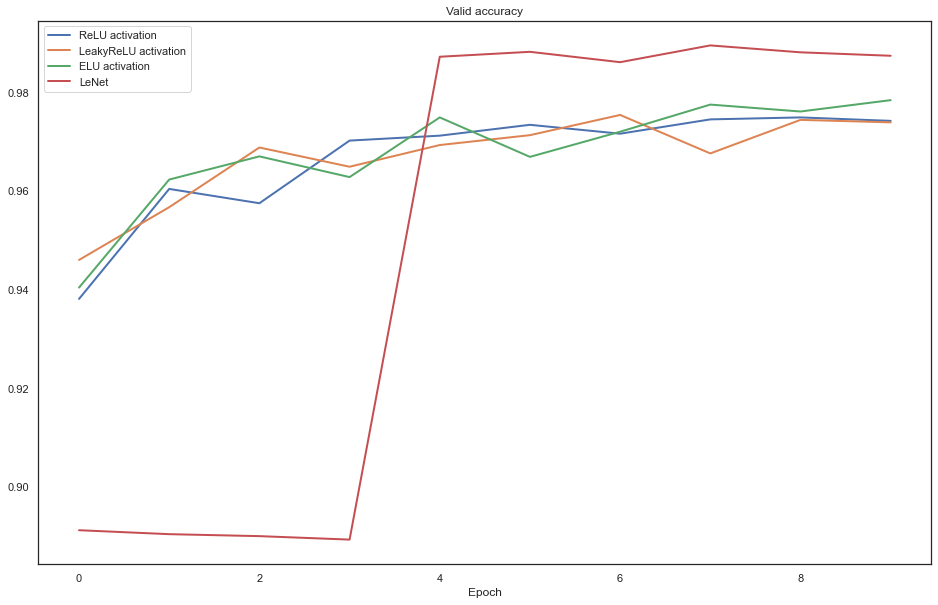

In [95]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [96]:
lenet_accuracy[-1]

0.9874

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99